<center><h1>Sentimental Analysis</h1></center>

To build our emotion detector we’ll use a great dataset from *Kaggle*. The datasets involves three basic emotions: **positive, negative and neutral polarities**. Given a text, our task will be to train a model that can classify it into one of these emotions.

In [6]:
# %pip install pandas --quiet
# %pip install matplotlib --quiet
# %pip install datasets --quiet
# %pip install umap-learn --quiet
# %pip install scikit-learn --quiet
# %pip install --upgrade numpy
# %pip install numpy --quiet
# %pip install numpy==1.26.4
# %pip install umap-learn --quiet
# %pip install xgboost --quiet
# %pip install transformers
# %pip install torch
# %pip install torch torchvision torchaudio

  Using cached torch-2.3.1-cp312-cp312-win_amd64.whl.metadata (26 kB)
  Using cached sympy-1.12.1-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.13.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.3.1-cp312-cp312-win_amd64.whl (159.7 MB)
Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
Using cached tbb-2021.13.0-py3-none-win_amd64.whl (286 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached sympy


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from datasets import DatasetDict
from transformers import AutoTokenizer
import torch
from transformers import AutoModel
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
import warnings
warnings.filterwarnings('ignore')

c:\Users\joaop\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('train.csv',
                 encoding='ISO-8859-1',
                 on_bad_lines='skip'
                 )
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
test = pd.read_csv('test.csv',
                   encoding='ISO-8859-1',
                   on_bad_lines='skip'
                   )
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [4]:
df.shape

(27481, 10)

In [5]:
test.shape

(4815, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [8]:
df[df.isna().any(axis=1)]

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
314,fdb77c3752,NaN,NaN,neutral,night,31-45,Namibia,2540905,823000.0,3


In [9]:
df = df.dropna(axis=0)
df.shape

(27480, 10)

In [10]:
df.isna().sum().sum()

0

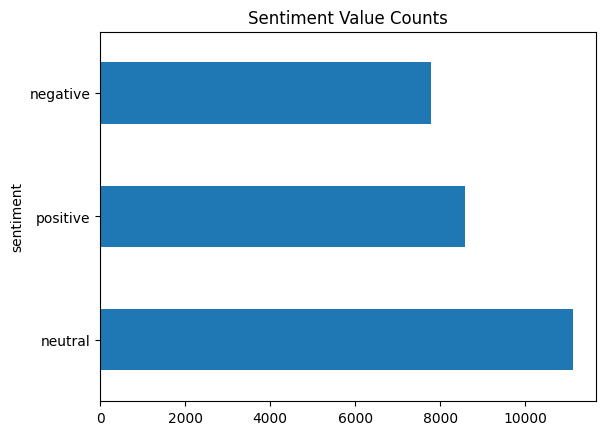

In [11]:
df['sentiment'].value_counts(ascending=False).plot(kind='barh', title='Sentiment Value Counts');

In [12]:
filtered_df = df[['text', 'sentiment']]
filtered_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [13]:
test = test.dropna()
test

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,noon,21-30,Nicaragua,6624554.0,120340.0,55.0
3530,416863ce47,All alone in this old house again. Thanks for...,positive,night,31-45,Niger,24206644.0,1266700.0,19.0
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,morning,46-60,Nigeria,206139589.0,910770.0,226.0
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,noon,60-70,North Korea,25778816.0,120410.0,214.0


In [14]:
filtered_test = test[['text', 'sentiment']]
filtered_test

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive
...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,All alone in this old house again. Thanks for...,positive
3531,I know what you mean. My little dog is sinkin...,negative
3532,_sutra what is your next youtube video gonna b...,positive


In [15]:
filtered_df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

<h2>1. Stratified Sampling in Pandas</h2>

In [16]:
((filtered_df['sentiment'].value_counts()) / len(filtered_df) * 100).round(2)

sentiment
neutral     40.45
positive    31.23
negative    28.32
Name: count, dtype: float64

In [17]:
strat_df = filtered_df.groupby(by='sentiment',
                               group_keys=False).apply(lambda x: x.sample(frac=0.45))
strat_df

,text,sentiment
23271,Layin n bed with a headache ughhhh...waitin o...,negative
9672,Just found out one of my coworkers that I actu...,negative
1329,i can`t studyyyyyyyyyyyyyyyyyyyyyyyyy i have ...,negative
26558,() Oh snap! Just broke my windshield while re...,negative
14919,"made it into leadership, buttt i`m still not h...",negative
...,...,...
18061,You be a good girl Whitney,positive
18181,Okay...So I have an AIM account now...Send me ...,positive
1693,"14 pages left to read, then it will be time to...",positive
18024,going shopping with my mammyy.... my makeup an...,positive


In [18]:
((strat_df['sentiment'].value_counts()) / len(strat_df) * 100).round(2)

sentiment
neutral     40.46
positive    31.23
negative    28.31
Name: count, dtype: float64

In [19]:
mapping = {'neutral': 0,
           'positive': 1,
           'negative': 2}

strat_df['number_sentiment'] = strat_df['sentiment'].map(mapping)
strat_df.head()

,text,sentiment,number_sentiment
23271,Layin n bed with a headache ughhhh...waitin o...,negative,2
9672,Just found out one of my coworkers that I actu...,negative,2
1329,i can`t studyyyyyyyyyyyyyyyyyyyyyyyyy i have ...,negative,2
26558,() Oh snap! Just broke my windshield while re...,negative,2
14919,"made it into leadership, buttt i`m still not h...",negative,2


In [20]:
strat_df.drop('sentiment', axis=1).to_csv('strat_df.csv', index=False)

In [21]:
filtered_test['number_sentiment'] = filtered_test['sentiment'].map(mapping)
filtered_test.drop('sentiment', axis=1).to_csv('filtered_test.csv', index=False)

In [22]:
sentiment = load_dataset("csv", data_files="strat_df.csv", encoding='ISO-8859-1', on_bad_lines='skip')

Generating train split: 12366 examples [00:00, 326993.72 examples/s]


In [23]:
type(sentiment)

datasets.dataset_dict.DatasetDict

In [24]:
train_ds = sentiment['train']
train_ds

Dataset({
    features: ['text', 'number_sentiment'],
    num_rows: 12366
})

In [25]:
sentiment

DatasetDict({
    train: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 12366
    })
})

In [26]:
sentiment_test = load_dataset("csv", data_files="filtered_test.csv", encoding='ISO-8859-1', on_bad_lines='skip')
test_ds = sentiment_test['train']
test_ds

Generating train split: 3534 examples [00:00, 228410.05 examples/s]


Dataset({
    features: ['text', 'number_sentiment'],
    num_rows: 3534
})

In [27]:
dataset_dict = DatasetDict({
    'train': train_ds,
    'test': test_ds
})

In [28]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 12366
    })
    test: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 3534
    })
})

In [29]:
dataset_dict.set_format(type='pandas')
format_df = sentiment['train'][:]
format_df

,text,number_sentiment
0,Layin n bed with a headache ughhhh...waitin o...,2
1,Just found out one of my coworkers that I actu...,2
2,i can`t studyyyyyyyyyyyyyyyyyyyyyyyyy i have ...,2
3,() Oh snap! Just broke my windshield while re...,2
4,"made it into leadership, buttt i`m still not h...",2
...,...,...
12361,You be a good girl Whitney,1
12362,Okay...So I have an AIM account now...Send me ...,1
12363,"14 pages left to read, then it will be time to...",1
12364,going shopping with my mammyy.... my makeup an...,1


In [30]:
mapping = {0: 'neutral',
           1: 'positive',
           2: 'negative'}

format_df['sentiment'] = format_df['number_sentiment'].map(mapping)

In [31]:
format_df['sentiment'].value_counts()

sentiment
neutral     5003
positive    3862
negative    3501
Name: count, dtype: int64

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens.

In [32]:
format_df['words per text'] = format_df['text'].apply(len)
format_df.head()

,text,number_sentiment,sentiment,words per text
0,Layin n bed with a headache ughhhh...waitin o...,2,negative,60
1,Just found out one of my coworkers that I actu...,2,negative,67
2,i can`t studyyyyyyyyyyyyyyyyyyyyyyyyy i have ...,2,negative,57
3,() Oh snap! Just broke my windshield while re...,2,negative,70
4,"made it into leadership, buttt i`m still not h...",2,negative,94


In [33]:
format_df.groupby(by='sentiment')['words per text'].describe(percentiles=[0.25, 0.50, 0.75, 0.99])

,count,mean,std,min,25%,50%,75%,99%,max
sentiment,,,,,,,,,
negative,3501.0,70.860040,35.156204,6.0,42.0,66.0,99.0,137.0,156.0
neutral,5003.0,65.439536,36.276473,3.0,35.0,60.0,94.0,137.0,207.0
positive,3862.0,70.480839,34.919844,5.0,42.0,67.0,99.0,137.0,149.0


<Axes: title={'center': 'words per text'}, xlabel='sentiment'>

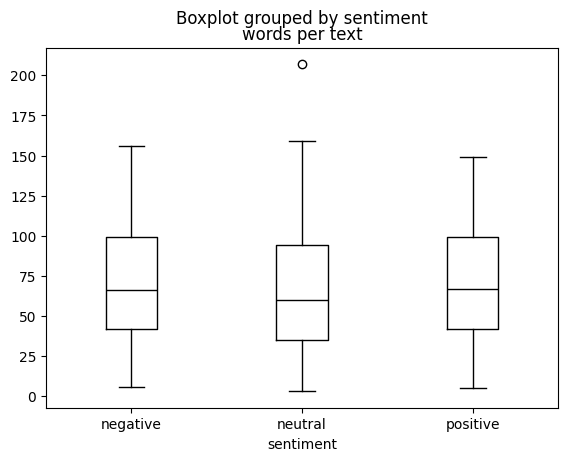

In [34]:
format_df.boxplot('words per text',
                  by='sentiment',
                  color='black',
                  grid=False)

From the plot we see that for each sentiment, most text are around 64 words long and the longest tweets are well below DistilBERT’s maximum context size.

In [35]:
dataset_dict.reset_format()
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 12366
    })
    test: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 3534
    })
})

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been *tokenized* and *encoded* as numerical vectors.

In [36]:
model_ckpt = "distilbert-base-uncased" # distilbert
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

<h2>2. Tokenizing the Whole Dataset</h2>

In [37]:
def tokenize(batch):
    return tokenizer(batch["text"],
                     padding=True, # padding=True will pad the examples with zeros to the size of the longest one in a batch. 
                     truncation=True) # truncation=True will truncate the examples to the model’s maximum context size.
# This function applies the tokenizer to a batch of examples,

In [38]:
print(tokenize(dataset_dict['train'][:2]))

{'input_ids': [[101, 3913, 2378, 1050, 2793, 2007, 1037, 14978, 1057, 5603, 23644, 2232, 1012, 1012, 1012, 3524, 2378, 2006, 2115, 2655, 1012, 1012, 1012, 102], [101, 2074, 2179, 2041, 2028, 1997, 2026, 11190, 2953, 11451, 2008, 1045, 2941, 2066, 2003, 2975, 1012, 102, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


Here we can see the result of padding: the first element of *input_ids* is shorter than the second, so zeros have been added to that element to make them the same length. 

The attention mask allows the model to ignore the padded parts of the input.

In [39]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 12366
    })
    test: Dataset({
        features: ['text', 'number_sentiment'],
        num_rows: 3534
    })
})

In [40]:
sentiment_encoded = dataset_dict.map(tokenize,
                                     batched=True,
                                     batch_size=None)

Map: 100%|██████████| 3534/3534 [00:00<00:00, 9984.00 examples/s] 


In [41]:
print(sentiment_encoded['train'].column_names)

['text', 'number_sentiment', 'input_ids', 'attention_mask']


<h2>3. Training a Text Classifier</h2>

In [42]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Here we’ve used PyTorch to check whether a GPU is available or not.
model = AutoModel.from_pretrained(model_ckpt).to(device)

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states.

In [43]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU or CPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [44]:
sentiment_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'number_sentiment', 'input_ids', 'attention_mask'],
        num_rows: 12366
    })
    test: Dataset({
        features: ['text', 'number_sentiment', 'input_ids', 'attention_mask'],
        num_rows: 3534
    })
})

In [45]:
sentiment_encoded.set_format("torch",
                             columns=['input_ids',
                                      'attention_mask',
                                      'number_sentiment'])

In [46]:
sentiment_hidden = sentiment_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 3534/3534 [04:07<00:00, 14.31 examples/s]


In [47]:
sentiment_hidden["train"].column_names

['text', 'number_sentiment', 'input_ids', 'attention_mask', 'hidden_state']

<h2>4. Creating a feature matrix</h2>

In [48]:
X_train = np.array(sentiment_hidden["train"]["hidden_state"])
X_valid = np.array(sentiment_hidden["test"]["hidden_state"])
y_train = np.array(sentiment_hidden["train"]["number_sentiment"])
y_valid = np.array(sentiment_hidden["test"]["number_sentiment"])
X_train.shape, X_valid.shape

((12366, 768), (3534, 768))

In [49]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
# Project the vectors down to 2D
mapper = umap.UMAP(n_components=2,
                   metric='cosine').fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['number_sentiment'] = y_train
df_emb.head()

,X,Y,number_sentiment
0,7.385810,8.443968,2
1,11.704251,5.970976,2
2,9.044003,7.827171,2
3,8.430548,4.898283,2
4,8.665452,6.468989,2


In [50]:
df_emb['sentiment'] = df_emb['number_sentiment'].map(mapping)
df_emb.head()

,X,Y,number_sentiment,sentiment
0,7.385810,8.443968,2,negative
1,11.704251,5.970976,2,negative
2,9.044003,7.827171,2,negative
3,8.430548,4.898283,2,negative
4,8.665452,6.468989,2,negative


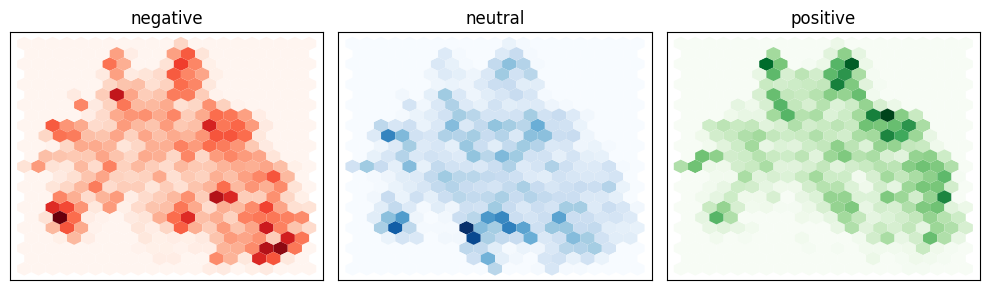

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()
cmpas = ['Reds', 'Blues', 'Greens']
labels = list(df_emb.sentiment.unique())

for i, (label, cmap) in enumerate(zip(labels, cmpas)):
  df_emb_sub = df_emb.query(f'number_sentiment == {i}')
  axes[i].hexbin(df_emb_sub['X'],
                 df_emb_sub['Y'],
                 cmap=cmap,
                 gridsize=20,
                 linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]),
  axes[i].set_yticks([])
plt.tight_layout()
plt.show()


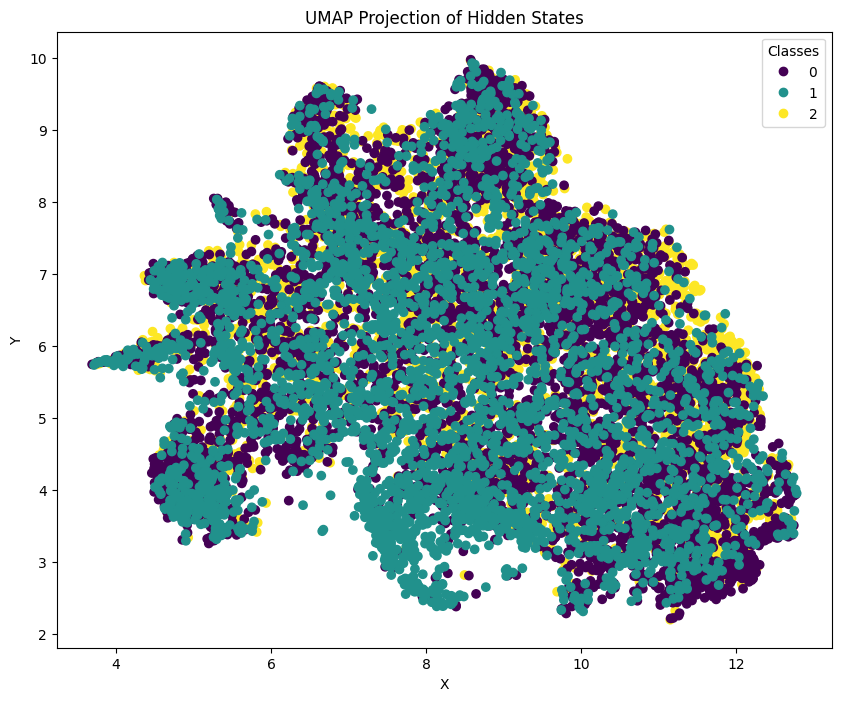

In [52]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_emb['X'],
                      df_emb['Y'],
                      c=df_emb['number_sentiment'],
                      cmap='viridis')

legend1 = plt.legend(*scatter.legend_elements(), title="Classes")


plt.title("UMAP Projection of Hidden States")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

<h2>5. Training a classifier</h2>

In [53]:
X = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_valid)])
y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_valid)])

lista = []

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier]:

    clf = model()
    scorings = ['accuracy']

    s= model_selection.cross_validate(clf, X, y, scoring=scorings, cv=3)

    for scoring in scorings:
      score = (f"{model.__name__:10} {scoring} {s[f'test_{scoring}'].mean():.4f} {s[f'test_{scoring}'].std():.4f}")
      lista.append(score)

df = pd.DataFrame([item.split() for item in lista],
                  columns=['Modelo', 'Métrica', 'Valor', 'Desvio Padrão'])
df['Valor'] = df['Valor'].astype(float)
df['Desvio Padrão'] = df['Desvio Padrão'].astype(float)
df

,Modelo,Métrica,Valor,Desvio Padrão
0,DummyClassifier,accuracy,0.4046,0.0001
1,LogisticRegression,accuracy,0.6830,0.0003
2,DecisionTreeClassifier,accuracy,0.4657,0.0031
3,KNeighborsClassifier,accuracy,0.5394,0.0012
4,GaussianNB,accuracy,0.5760,0.0114
5,SVC,accuracy,0.6679,0.0023
6,RandomForestClassifier,accuracy,0.6014,0.0029
7,XGBClassifier,accuracy,0.6491,0.0028


In [54]:
# Increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
round(lr_clf.score(X_valid, y_valid), 2)

0.69

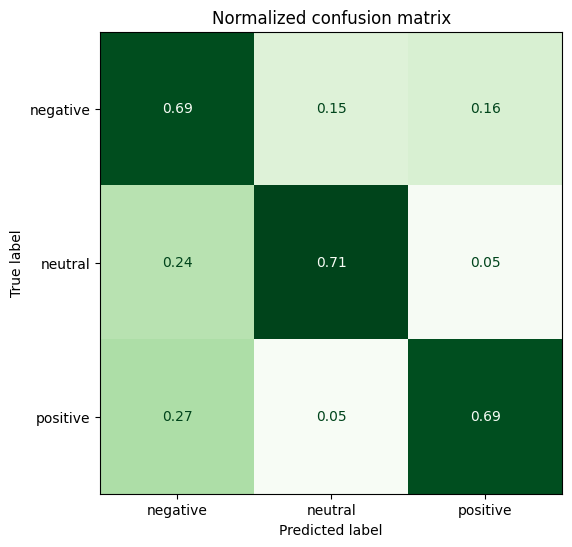

In [55]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_pred=y_preds, y_true=y_true, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot(values_format='.2f',
            ax=ax,
            colorbar=False,
            cmap='Greens')
  plt.title('Normalized confusion matrix')
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)